In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import math
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix

# Load data

In [20]:
# Load data
df = pd.read_csv('../data/HR_data_wide_physiological.csv')
df = df.dropna()

df_emotions = pd.read_csv('../data/HR_data_wide_emotions.csv')
df_emotions = df.dropna()

diff_emotions_columns = ["Frustrated_diff_phase1_phase2","upset_diff_phase1_phase2","hostile_diff_phase1_phase2",
                         "alert_diff_phase1_phase2","ashamed_diff_phase1_phase2","inspired_diff_phase1_phase2",
                         "nervous_diff_phase1_phase2","attentive_diff_phase1_phase2","afraid_diff_phase1_phase2",
                         "active_diff_phase1_phase2","determined_diff_phase1_phase2"]

emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

phys_var_columns1 = ['HR_TD_Mean_diff_phase1_phase2', 'HR_TD_Median_diff_phase1_phase2', 'HR_TD_std_diff_phase1_phase2',
       'HR_TD_Min_diff_phase1_phase2', 'HR_TD_Max_diff_phase1_phase2', 'HR_TD_AUC_diff_phase1_phase2', 'HR_TD_Kurtosis_diff_phase1_phase2', 'HR_TD_Skew_diff_phase1_phase2',
       'HR_TD_Slope_min_diff_phase1_phase2', 'HR_TD_Slope_max_diff_phase1_phase2', 'HR_TD_Slope_mean_diff_phase1_phase2', 'HR_TD_Slope_diff_phase1_phase2',
       'TEMP_TD_Mean_diff_phase1_phase2', 'TEMP_TD_Median_diff_phase1_phase2', 'TEMP_TD_std_diff_phase1_phase2', 'TEMP_TD_Min_diff_phase1_phase2',
       'TEMP_TD_Max_diff_phase1_phase2', 'TEMP_TD_AUC_diff_phase1_phase2', 'TEMP_TD_Kurtosis_diff_phase1_phase2', 'TEMP_TD_Skew_diff_phase1_phase2',
       'TEMP_TD_Slope_min_diff_phase1_phase2', 'TEMP_TD_Slope_max_diff_phase1_phase2', 'TEMP_TD_Slope_mean_diff_phase1_phase2',
       'TEMP_TD_Slope_diff_phase1_phase2', 'EDA_TD_P_Mean_diff_phase1_phase2', 'EDA_TD_P_Median_diff_phase1_phase2', 'EDA_TD_P_std_diff_phase1_phase2',
       'EDA_TD_P_Min_diff_phase1_phase2', 'EDA_TD_P_Max_diff_phase1_phase2', 'EDA_TD_P_AUC_diff_phase1_phase2', 'EDA_TD_P_Kurtosis_diff_phase1_phase2',
       'EDA_TD_P_Skew_diff_phase1_phase2', 'EDA_TD_P_Slope_min_diff_phase1_phase2', 'EDA_TD_P_Slope_max_diff_phase1_phase2',
       'EDA_TD_P_Slope_mean_diff_phase1_phase2', 'EDA_TD_P_Slope_diff_phase1_phase2', 'EDA_TD_T_Mean_diff_phase1_phase2',
       'EDA_TD_T_Median_diff_phase1_phase2', 'EDA_TD_T_std_diff_phase1_phase2', 'EDA_TD_T_Min_diff_phase1_phase2', 'EDA_TD_T_Max_diff_phase1_phase2',
       'EDA_TD_T_AUC_diff_phase1_phase2', 'EDA_TD_T_Kurtosis_diff_phase1_phase2', 'EDA_TD_T_Skew_diff_phase1_phase2',
       'EDA_TD_T_Slope_min_diff_phase1_phase2', 'EDA_TD_T_Slope_max_diff_phase1_phase2', 'EDA_TD_T_Slope_mean_diff_phase1_phase2',
       'EDA_TD_T_Slope_diff_phase1_phase2', 'EDA_TD_P_Peaks_diff_phase1_phase2', 'EDA_TD_P_RT_diff_phase1_phase2', 'EDA_TD_P_ReT_diff_phase1_phase2']

df_diff_phys = df[phys_var_columns1]

In [3]:
# Remove the NANs

df_diff_phys = np.asarray(df_diff_phys)

minX = list(np.min(df_diff_phys, axis=0)) # data range min
maxX = list(np.max(df_diff_phys, axis=0)) # data range max

[N, p] = df_diff_phys.shape

clustersNr = 10
list_of_clusters = range(1,clustersNr+1)
Nsim = 20
W = np.zeros(clustersNr)
Wu = np.zeros((clustersNr, Nsim))
for nrClusters in list_of_clusters: # Want actual number included
    kmeans = KMeans(n_clusters=nrClusters).fit(df_diff_phys)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((df_diff_phys[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku

        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

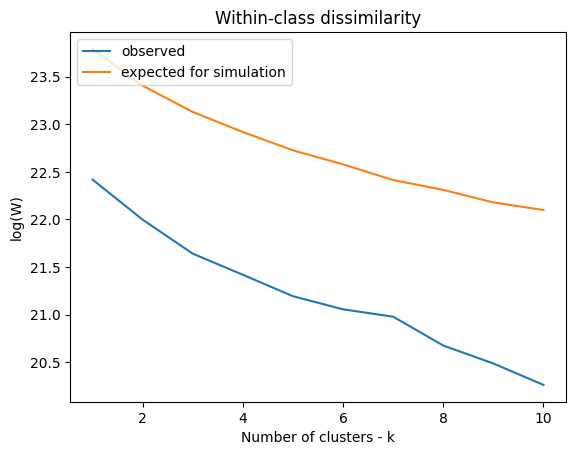

In [4]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

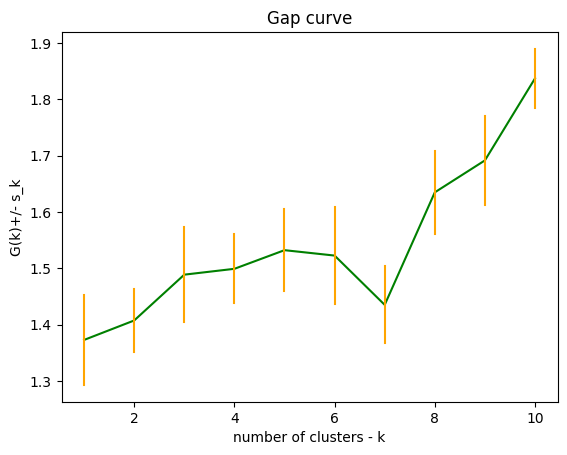

In [5]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

### How are the groups based differences on physiological variables?

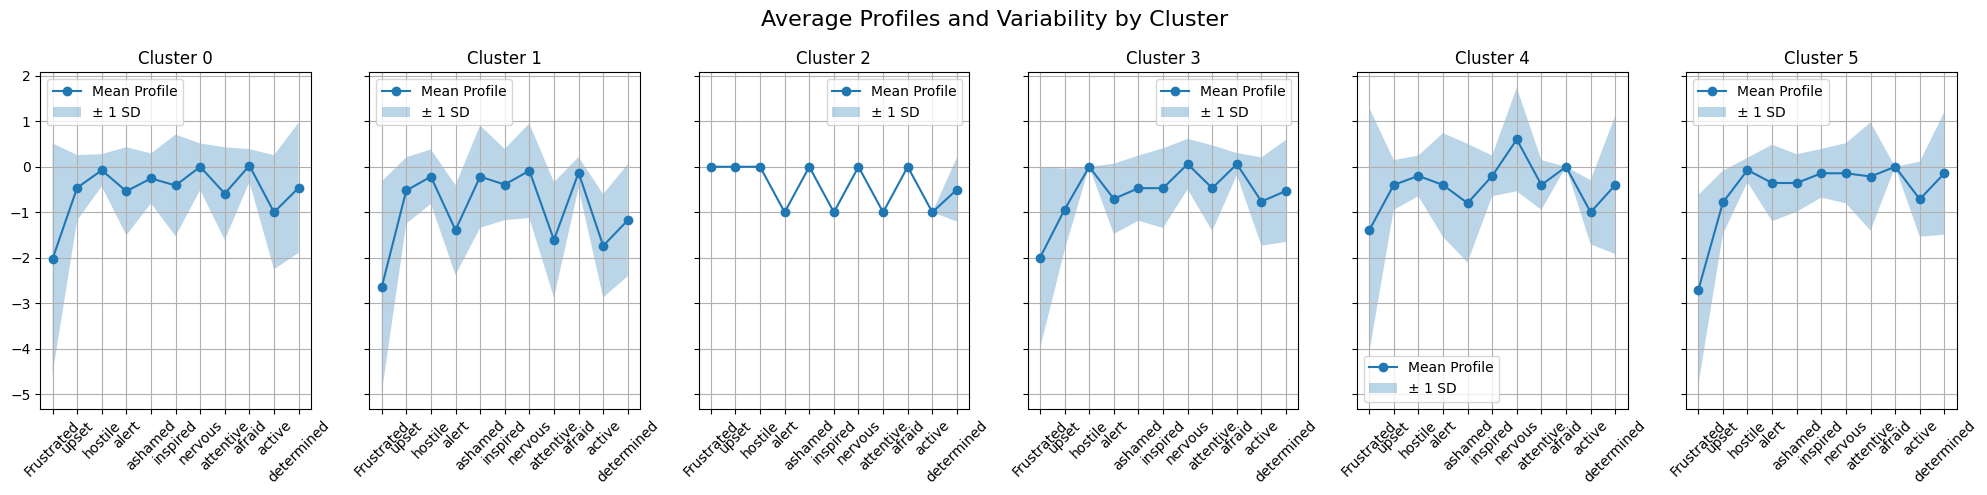

In [13]:
# Assuming your df_emotions is already defined and preprocessed

# If df_emotions is a numpy array, convert it to DataFrame
df_diff_emotions = pd.DataFrame(df_diff_phys, columns=phys_var_columns)

# 2. Perform KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_diff_phys)
labels = kmeans.labels_

# 3. Create a DataFrame to hold the cluster assignments
df_phys_clustered = df_emotions[diff_emotions_columns].copy()
df_phys_clustered['Cluster'] = labels

# 4. Prepare for plotting
n_clusters = 6
fig, axs = plt.subplots(1, n_clusters, figsize=(20, 5), sharey=True)

for cluster_id in range(n_clusters):
    cluster_data = df_phys_clustered[df_phys_clustered['Cluster'] == cluster_id]
    
    # Compute mean and standard deviation for this cluster
    mean_profile = cluster_data.iloc[:, :-1].mean()  # exclude 'Cluster' column
    std_profile = cluster_data.iloc[:, :-1].std()
    
    x = np.arange(len(diff_emotions_columns))
    
    # Plot
    axs[cluster_id].plot(x, mean_profile, marker='o', label='Mean Profile')
    axs[cluster_id].fill_between(x, mean_profile - std_profile, mean_profile + std_profile, alpha=0.3, label='± 1 SD')
    
    axs[cluster_id].set_title(f'Cluster {cluster_id}')
    axs[cluster_id].set_xticks(x)
    axs[cluster_id].set_xticklabels(emotions_columns, rotation=45)
    axs[cluster_id].grid(True)
    axs[cluster_id].legend()

fig.suptitle('Average Profiles and Variability by Cluster', fontsize=16)
plt.tight_layout()
plt.show()

## Repeat for the phase2-phase3 differences

In [21]:
# Load data
df = pd.read_csv('../data/HR_data_wide_physiological.csv')
df = df.dropna()

df_emotions = pd.read_csv('../data/HR_data_wide_emotions.csv')
df_emotions = df.dropna()

diff_emotions_columns = ["Frustrated_diff_phase2_phase3","upset_diff_phase2_phase3","hostile_diff_phase2_phase3",
                         "alert_diff_phase2_phase3","ashamed_diff_phase2_phase3","inspired_diff_phase2_phase3",
                         "nervous_diff_phase2_phase3","attentive_diff_phase2_phase3","afraid_diff_phase2_phase3",
                         "active_diff_phase2_phase3","determined_diff_phase2_phase3"]

emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

phys_var_columns2 = ['HR_TD_Mean_diff_phase2_phase3', 'HR_TD_Median_diff_phase2_phase3', 'HR_TD_std_diff_phase2_phase3',
       'HR_TD_Min_diff_phase2_phase3', 'HR_TD_Max_diff_phase2_phase3', 'HR_TD_AUC_diff_phase2_phase3', 'HR_TD_Kurtosis_diff_phase2_phase3', 'HR_TD_Skew_diff_phase2_phase3',
       'HR_TD_Slope_min_diff_phase2_phase3', 'HR_TD_Slope_max_diff_phase2_phase3', 'HR_TD_Slope_mean_diff_phase2_phase3', 'HR_TD_Slope_diff_phase2_phase3',
       'TEMP_TD_Mean_diff_phase2_phase3', 'TEMP_TD_Median_diff_phase2_phase3', 'TEMP_TD_std_diff_phase2_phase3', 'TEMP_TD_Min_diff_phase2_phase3',
       'TEMP_TD_Max_diff_phase2_phase3', 'TEMP_TD_AUC_diff_phase2_phase3', 'TEMP_TD_Kurtosis_diff_phase2_phase3', 'TEMP_TD_Skew_diff_phase2_phase3',
       'TEMP_TD_Slope_min_diff_phase2_phase3', 'TEMP_TD_Slope_max_diff_phase2_phase3', 'TEMP_TD_Slope_mean_diff_phase2_phase3',
       'TEMP_TD_Slope_diff_phase2_phase3', 'EDA_TD_P_Mean_diff_phase2_phase3', 'EDA_TD_P_Median_diff_phase2_phase3', 'EDA_TD_P_std_diff_phase2_phase3',
       'EDA_TD_P_Min_diff_phase2_phase3', 'EDA_TD_P_Max_diff_phase2_phase3', 'EDA_TD_P_AUC_diff_phase2_phase3', 'EDA_TD_P_Kurtosis_diff_phase2_phase3',
       'EDA_TD_P_Skew_diff_phase2_phase3', 'EDA_TD_P_Slope_min_diff_phase2_phase3', 'EDA_TD_P_Slope_max_diff_phase2_phase3',
       'EDA_TD_P_Slope_mean_diff_phase2_phase3', 'EDA_TD_P_Slope_diff_phase2_phase3', 'EDA_TD_T_Mean_diff_phase2_phase3',
       'EDA_TD_T_Median_diff_phase2_phase3', 'EDA_TD_T_std_diff_phase2_phase3', 'EDA_TD_T_Min_diff_phase2_phase3', 'EDA_TD_T_Max_diff_phase2_phase3',
       'EDA_TD_T_AUC_diff_phase2_phase3', 'EDA_TD_T_Kurtosis_diff_phase2_phase3', 'EDA_TD_T_Skew_diff_phase2_phase3',
       'EDA_TD_T_Slope_min_diff_phase2_phase3', 'EDA_TD_T_Slope_max_diff_phase2_phase3', 'EDA_TD_T_Slope_mean_diff_phase2_phase3',
       'EDA_TD_T_Slope_diff_phase2_phase3', 'EDA_TD_P_Peaks_diff_phase2_phase3', 'EDA_TD_P_RT_diff_phase2_phase3', 'EDA_TD_P_ReT_diff_phase2_phase3']

df_diff_phys = df[phys_var_columns2]

In [15]:
# Remove the NANs

df_diff_phys = np.asarray(df_diff_phys)

minX = list(np.min(df_diff_phys, axis=0)) # data range min
maxX = list(np.max(df_diff_phys, axis=0)) # data range max

[N, p] = df_diff_phys.shape

clustersNr = 10
list_of_clusters = range(1,clustersNr+1)
Nsim = 20
W = np.zeros(clustersNr)
Wu = np.zeros((clustersNr, Nsim))
for nrClusters in list_of_clusters: # Want actual number included
    kmeans = KMeans(n_clusters=nrClusters).fit(df_diff_phys)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((df_diff_phys[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku

        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

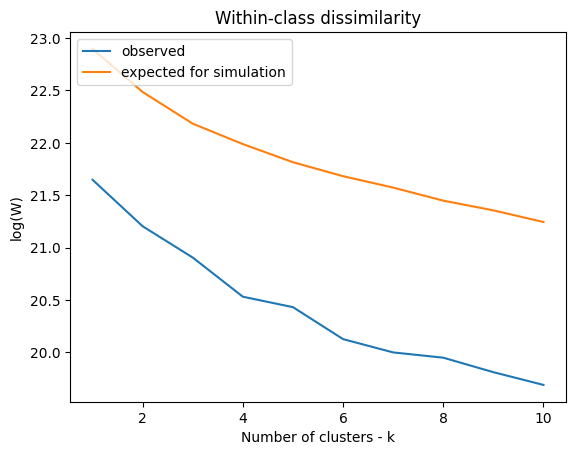

In [16]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

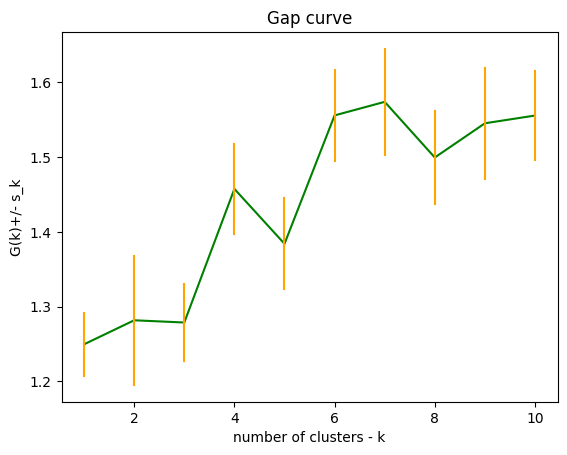

In [17]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

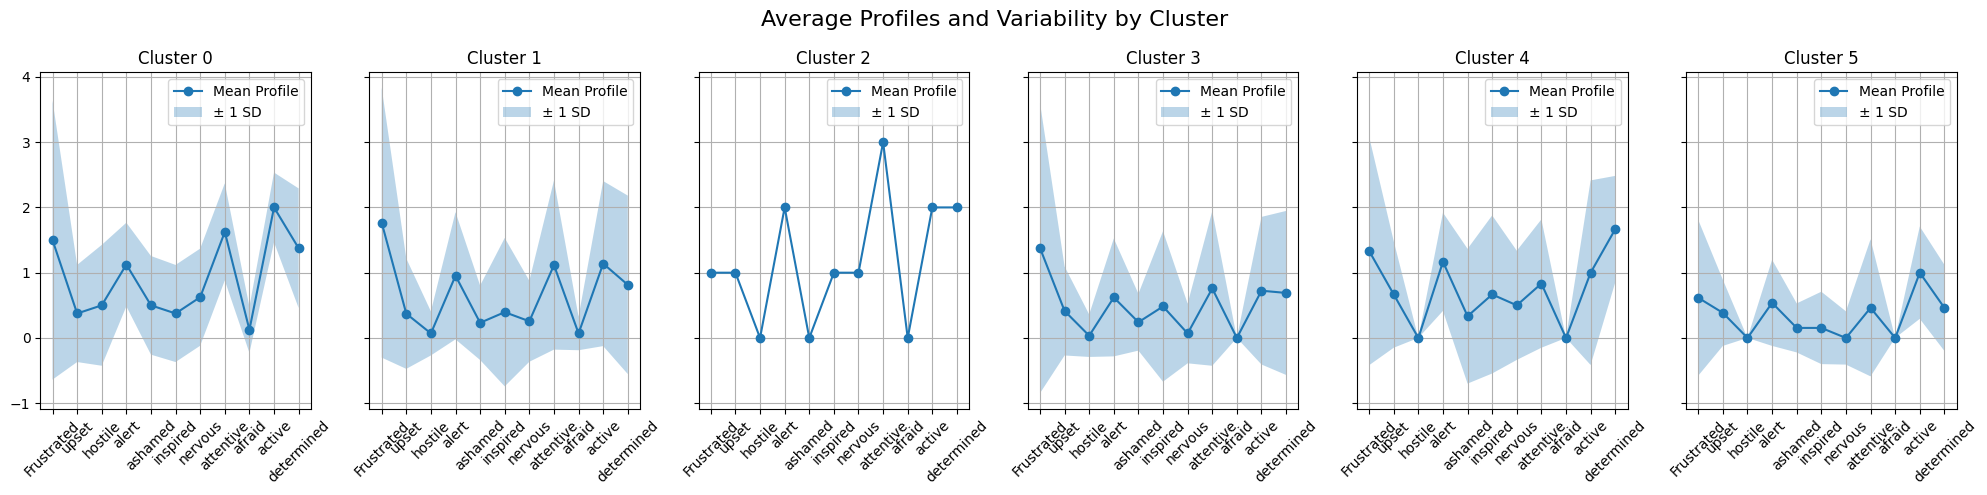

In [18]:
# Assuming your df_emotions is already defined and preprocessed

# If df_emotions is a numpy array, convert it to DataFrame
df_diff_emotions = pd.DataFrame(df_diff_phys, columns=phys_var_columns)

# 2. Perform KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_diff_phys)
labels = kmeans.labels_

# 3. Create a DataFrame to hold the cluster assignments
df_phys_clustered = df_emotions[diff_emotions_columns].copy()
df_phys_clustered['Cluster'] = labels

# 4. Prepare for plotting
n_clusters = 6
fig, axs = plt.subplots(1, n_clusters, figsize=(20, 5), sharey=True)

for cluster_id in range(n_clusters):
    cluster_data = df_phys_clustered[df_phys_clustered['Cluster'] == cluster_id]
    
    # Compute mean and standard deviation for this cluster
    mean_profile = cluster_data.iloc[:, :-1].mean()  # exclude 'Cluster' column
    std_profile = cluster_data.iloc[:, :-1].std()
    
    x = np.arange(len(diff_emotions_columns))
    
    # Plot
    axs[cluster_id].plot(x, mean_profile, marker='o', label='Mean Profile')
    axs[cluster_id].fill_between(x, mean_profile - std_profile, mean_profile + std_profile, alpha=0.3, label='± 1 SD')
    
    axs[cluster_id].set_title(f'Cluster {cluster_id}')
    axs[cluster_id].set_xticks(x)
    axs[cluster_id].set_xticklabels(emotions_columns, rotation=45)
    axs[cluster_id].grid(True)
    axs[cluster_id].legend()

fig.suptitle('Average Profiles and Variability by Cluster', fontsize=16)
plt.tight_layout()
plt.show()

## See Changes intra patients

In [22]:
# Load (again) data
df = pd.read_csv('../data/HR_data_wide_physiological.csv')
df = df.dropna()

df_diff1_physiological = df[phys_var_columns1]

df_diff2_physiological = df[phys_var_columns2]

In [24]:
kmeans1 = KMeans(n_clusters=6, random_state=0).fit(df_diff1_physiological)
df['cluster_phase1'] = np.nan
df.loc[df.index, 'cluster_phase1'] = kmeans1.labels_

kmeans2 = KMeans(n_clusters=6, random_state=0).fit(df_diff2_physiological)
df['cluster_phase2'] = np.nan
df.loc[df.index, 'cluster_phase2'] = kmeans2.labels_

# First merge phase1 and phase2
df_temp = pd.merge(
    df[['Individual', 'cluster_phase1']],
    df[['Individual', 'cluster_phase2']],
    on='Individual',
    how='outer'
)

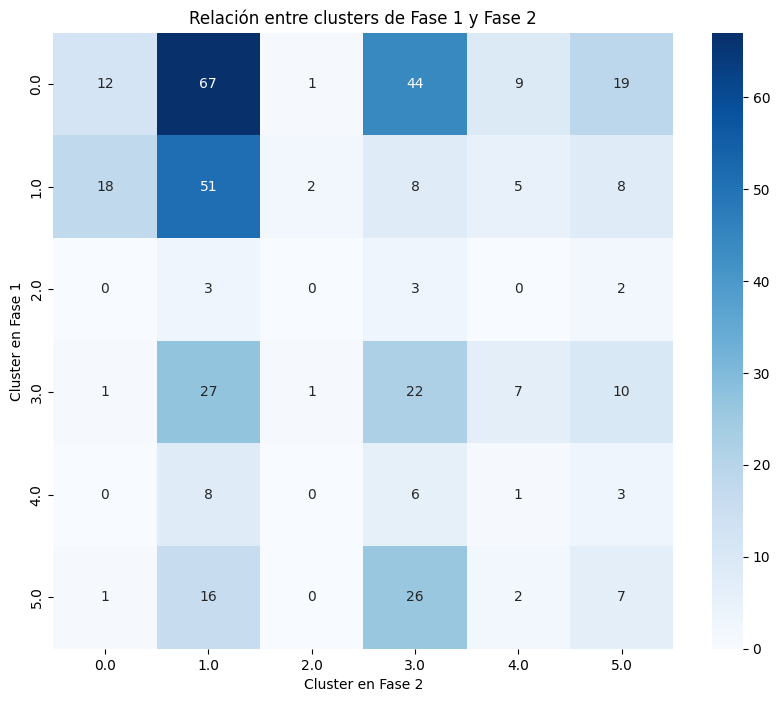

In [25]:
# Suponiendo que tu DataFrame se llama df
# Creamos una tabla de conteos entre cluster de fase1 y fase2
confusion = pd.crosstab(df_temp['cluster_phase1'], df_temp['cluster_phase2'])

# Graficamos
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title('Relación entre clusters de Fase 1 y Fase 2')
plt.xlabel('Cluster en Fase 2')
plt.ylabel('Cluster en Fase 1')
plt.show()

In [26]:
import plotly.graph_objects as go

df = df_temp

# Primero contamos las transiciones entre fase 1 -> fase 2
transitions_12 = df.groupby(['cluster_phase1', 'cluster_phase2']).size().reset_index(name='count')

# Crear las listas necesarias para el Sankey
max_phase1 = int(df['cluster_phase1'].max()) + 1
max_phase2 = int(df['cluster_phase2'].max()) + 1

# Para fase1 -> fase2
source_12 = transitions_12['cluster_phase1'].astype(int)
target_12 = transitions_12['cluster_phase2'].astype(int) + max_phase1  # desplazamos para no solaparlos
value_12 = transitions_12['count']

# Crear las etiquetas
labels = (
    [f'Fase1 Cluster {i}' for i in sorted(df['cluster_phase1'].dropna().unique())] +
    [f'Fase2 Cluster {i}' for i in sorted(df['cluster_phase2'].dropna().unique())] 
)

# Crear el diagrama de Sankey
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels
    ),
    link = dict(
      source = source_12,
      target = target_12,
      value = value_12
    ))])

fig.update_layout(title_text="Flujo de Pacientes entre Clusters Fase 1 y Fase 2", font_size=10)
fig.show()